In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import glob
import scipy

In [28]:
def directory():
    train_dir = "/content/drive/MyDrive/ML Project/Pneumonia//train"
    valid_dir = "/content/drive/MyDrive/ML Project/Pneumonia/valid"
    test_dir = "/content/drive/MyDrive/ML Project/Pneumonia/test"
    return train_dir,valid_dir,test_dir
train_dir,valid_dir,test_dir=directory()

In [29]:


def preprocess(train_dir,valid_dir,test_dir,batch_size,target_size,rescale,zoom_range,vertical_flip):
    train_datagen=ImageDataGenerator(rescale=rescale,zoom_range=zoom_range ,vertical_flip=vertical_flip)
    test_datagen=ImageDataGenerator(rescale=rescale)
    valid_datagen=ImageDataGenerator(rescale=rescale)

    train_generator = train_datagen.flow_from_directory(train_dir,target_size=target_size,batch_size=batch_size,class_mode="binary")

    valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=target_size,batch_size=batch_size,class_mode="binary")

    test_generator = test_datagen.flow_from_directory(test_dir,target_size=target_size,batch_size=batch_size,class_mode="binary")


    return train_generator,valid_generator,test_generator

    
train_set,valid_set,test_set=preprocess(train_dir,valid_dir,test_dir,batch_size=28,target_size=(150,150),rescale=1./255.,zoom_range=0.3,vertical_flip=True)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [30]:

def model(input_shape,activation,lr):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), activation='relu',padding='same',
                        input_shape=(150, 150, 3)))
    model.add(layers.Conv2D(64, (5,5), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.RMSprop(lr=lr),loss='binary_crossentropy',metrics=['accuracy'])
    return model
model=model(input_shape=(150,150,3),activation='relu',lr=0.0005)

In [31]:
def train(train_set,valid_set,epochs,batch_size):
    filepath="weights-improvement.hdf5"
    checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto')
    callbacks_list = [checkpoint]
    history = model.fit_generator(train_set, steps_per_epoch=train_set.samples // batch_size, 
           epochs=epochs, validation_data=valid_set,callbacks=callbacks_list)
    return history


train_history=train(train_set,valid_set,epochs=50,batch_size=28)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
186/186 [==============================] - 79s 419ms/step - loss: 0.8733 - accuracy: 0.7357 - val_loss: 0.6369 - val_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.63685, saving model to weights-improvement.hdf5
Epoch 2/50
186/186 [==============================] - 79s 421ms/step - loss: 0.4759 - accuracy: 0.7917 - val_loss: 0.5117 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.63685 to 0.51171, saving model to weights-improvement.hdf5
Epoch 3/50
186/186 [==============================] - 78s 421ms/step - loss: 0.3874 - accuracy: 0.8402 - val_loss: 0.6462 - val_accuracy: 0.7500

Epoch 00003: val_loss did not improve from 0.51171
Epoch 4/50
186/186 [==============================] - 79s 422ms/step - loss: 0.3492 - accuracy: 0.8666 - val_loss: 0.5208 - val_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.51171
Epoch 5/50
186/186 [==============================] - 78s 421ms/step - loss: 0.3177 - accuracy: 0.8741 - val_loss: 0.6143 - 

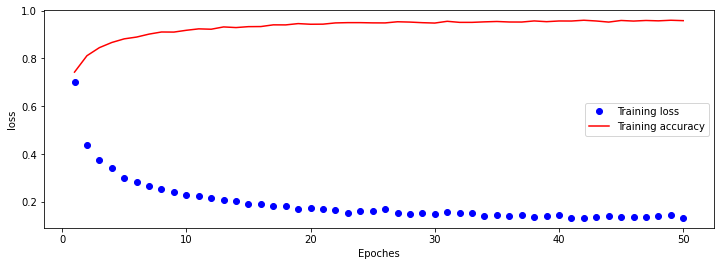

In [32]:
def plot(history,figsize,y,x):
    history_dict=history.history
    loss=history_dict[y]
    acc=history_dict[x]
    epoch=range(1,len(acc)+1)
    plt.figure(figsize=figsize)
    plt.plot(epoch,loss,'bo',label='Training loss')
    plt.plot(epoch,acc,'r',label='Training accuracy')
    plt.xlabel('Epoches')
    plt.ylabel('loss')
    plt.legend()
plot(train_history,(12,4),y='loss',x='accuracy')


In [33]:
def test(test_set):
    results = model.evaluate(test_set)
    return results

results=test(test_set)
print("test set resulat is",results)


23/23 [==============================] - 6s 255ms/step - loss: 0.3172 - accuracy: 0.9167
test set resulat is [0.31722578406333923, 0.9166666865348816]


In [34]:
 def save(name):
     model.save(name)

save("pne_conv")

INFO:tensorflow:Assets written to: pne_conv/assets


In [35]:
model.load_weights("weights-improvement.hdf5")

In [36]:
    model.compile(optimizer=optimizers.RMSprop(lr=0.0006),loss='binary_crossentropy',metrics=['accuracy'])


In [37]:
def test_best(test_set):
    results = model.evaluate(test_set)
    return results

results=test_best(test_set)
print("test set resulat is",results)

23/23 [==============================] - 6s 248ms/step - loss: 0.2985 - accuracy: 0.9142
test set resulat is [0.23533958196640015, 0.9310897588729858]
